## Training ResNet50 model

In [1]:
import numpy as np
import tensorflow as tf
import skimage.transform
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.applications.resnet import ResNet50

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.array([skimage.transform.resize(image, (32, 32)) for image in np.expand_dims(x_train, -1)])[:10000]
x_test = np.array([skimage.transform.resize(image, (32, 32)) for image in np.expand_dims(x_test, -1)])
y_train = y_train.astype('int')[:10000]
y_test = y_test.astype('int')

train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [942, 1027, 1016, 1019, 974, 989, 1021, 1022, 990, 1000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [3]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [4]:
%%time
model = ResNet50(classes = 10, weights = None, input_shape=(32, 32, 1))

trainable = False
for layer in model.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs = 4, batch_size = 16, validation_split = 0.2, verbose = 1)


Epoch 1/4
500/500 [==============================] - 91s 178ms/step - loss: 1.3732 - accuracy: 0.6139 - val_loss: 2.3960 - val_accuracy: 0.1610
Epoch 2/4
500/500 [==============================] - 83s 166ms/step - loss: 0.9636 - accuracy: 0.6926 - val_loss: 1.2229 - val_accuracy: 0.6030
Epoch 3/4
500/500 [==============================] - 83s 165ms/step - loss: 0.8250 - accuracy: 0.7335 - val_loss: 0.9222 - val_accuracy: 0.6880
Epoch 4/4
500/500 [==============================] - 82s 165ms/step - loss: 0.7497 - accuracy: 0.7483 - val_loss: 2.1827 - val_accuracy: 0.6805
CPU times: total: 25min 12s
Wall time: 5min 40s


## Training Siamese model

In [9]:

def distance(vectors):
    x, y = vectors
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

img_a_feat = model(tf.keras.layers.Input(shape = x_train.shape[1:], name='Image A input'))
img_b_feat = model(tf.keras.layers.Input(shape = x_train.shape[1:], name='Image B input'))

features = tf.keras.layers.Lambda(distance)([img_a_feat, img_b_feat])
features = tf.keras.layers.Dense(16, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 lambda_2 (Lambda)              (None, 1)            0           ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 16)           32          ['lambda_2[1][0]']   

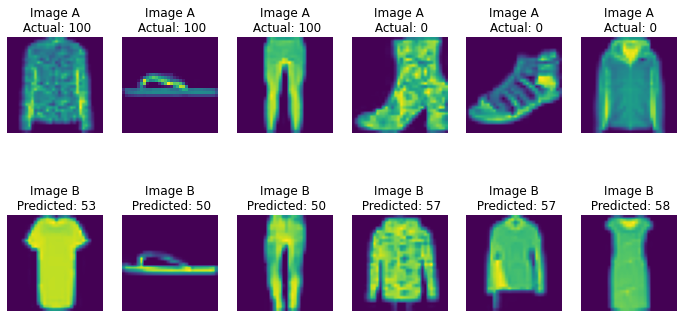

In [10]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [11]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 2,
    verbose = True)

Epoch 1/2
500/500 [==============================] - 113s 225ms/step - loss: 0.5132 - mae: 0.3748 - val_loss: 0.4402 - val_mae: 0.3189
Epoch 2/2
500/500 [==============================] - 98s 196ms/step - loss: 0.3967 - mae: 0.2618 - val_loss: 0.4017 - val_mae: 0.2549


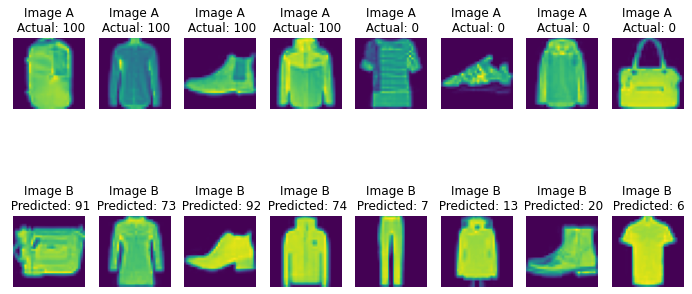

In [14]:
_ = show_model_output(4)

## Organising t-SNE

In [15]:
%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 14s 178ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.017s...


C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 0.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000


C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.903076
[t-SNE] KL divergence after 500 iterations: 0.860807
CPU times: total: 3min 45s
Wall time: 28 s


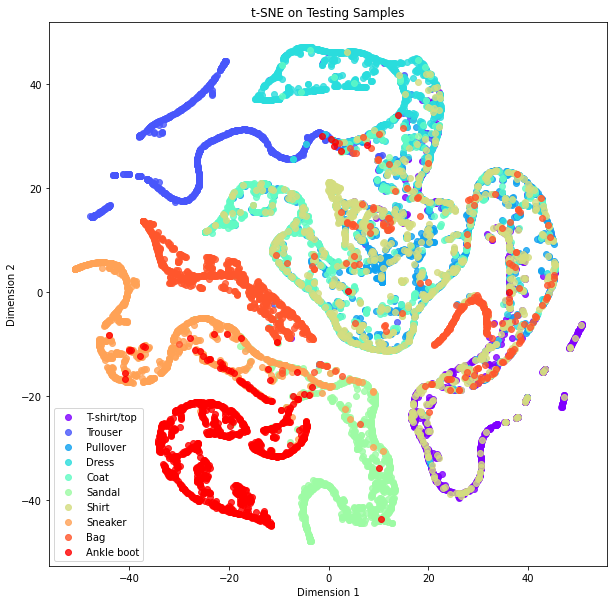

In [16]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)